# COMP5623 Coursework 2 on Image Caption Generation
# By Jordan Vauls, MM19JV


## Text preparation 

We need to build a vocabulary.

In [58]:
# Mounted Drive if using Colab; otherwise, your local path
root = "C:/Users/JordanLaptop/Desktop/AICW2/" # <--- replace this with your root data directory
caption_dir = root + "captions/"                       # <--- replace these too
image_dir = root + "images/"                           # <---
token_file = "Flickr8k.token.txt"

A helper function to read in our ground truth text file.

In [59]:
def read_lines(filepath):
    """ Open the ground truth captions into memory, line by line. """
    file = open(filepath, 'r')
    lines = []

    while True: 
        # Get next line from file until there's no more
        line = file.readline() 
        if not line: 
            break
        lines.append(line.strip())
    file.close() 
    return lines

You can read all the ground truth captions (5 per image), into memory as follows:

In [60]:
lines = read_lines(caption_dir + token_file)

In [61]:
lines[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [62]:
class Vocabulary(object):
    """Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # Intially, set both the IDs and words to empty dictionaries.
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
    def add_word(self, word):
        # If the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # Increment the ID for the next word
            self.idx += 1
    def __call__(self, word):
        # If we try to access a word in the dictionary which does not exist, return the <unk> id
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]
    
    def __return__(self, idx):
        # If we try to access an index in the dictionary which does not exist, return the <unk> id
        if not idx in self.idx2word:
            return self.idx2word['<unk>']
        return self.idx2word[idx]
    
    def __len__(self):
        return len(self.word2idx)

Extract all the words from ```lines```, and create a list of them in a variable ```words```, for example:

```words = ["a", "an", "the", "cat"... ]```

No need to worry about duplicates.


In [63]:
import string

images, captions = [], []
for entry in lines:
    
    # Split the string into two around the '#' character, to isolate file name and remainder. 
    imagedir = entry.split('.', 1)[0]
    imagedir, captiontxt = entry.split('#', 1)
   
    # Remove punctuation and unwanted characters from caption, make all characters lower case.
    captiontxt = ''.join(i for i in captiontxt[2:] if i not in string.punctuation)
    captiontxt = captiontxt.lower()
    
    # Append each entry to the respective list.
    images.append(imagedir)
    captions.append(captiontxt)
    
images


['1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1001773457_577c3a7d70.jpg',
 '1001773457_577c3a7d70.jpg',
 '1001773457_577c3a7d70.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1003163366_44323f5815.jpg',
 '1003163366_44323f5815.jpg',
 '1003163366_44323f5815.jpg',
 '1003163366_44323f5815.jpg',
 '1003163366_44323f5815.jpg',
 '1007129816_e794419615.jpg',
 '1007129816_e794419615.jpg',
 '1007129816_e794419615.jpg',
 '1007129816_e794419615.jpg',
 '1007129816_e794419615.jpg',
 '1007320043_627395c3d8.jpg',
 '1007320043_627395c3d8.jpg',
 '1007320043_627395c3d8.jpg',
 '1007320043_627395c3d8.jpg',
 '1007320043_627395c3d8.jpg',
 '1009434119_febe49276a.jpg',
 '1009434119_febe49276a.jpg',
 '1009434119_febe49276a.jpg',
 '10094341

Build the vocabulary.

In [64]:
# Create a vocab instance
vocab = Vocabulary()

# Add the token words first
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')

Add the rest of the words from the parsed captions:

``` vocab.add_word('new_word')```

Don't add words that appear three times or less.

In [65]:
allwords = []
for i in range(len(captions)):
    
    # Split each caption into separate words.
    splitcaptions = captions[i].split()
    
    # Add each separate word to the list 'words'.
    for j in range(len(splitcaptions)):
        allwords.append(splitcaptions[j])
        


In [66]:
# Now use a counter to check frequency of words in allwords, using import.
from collections import Counter
count = Counter(allwords)

# Append all words of frequency greater than 3 to a new list, 'freqwords'.
freqwords = []
for string in allwords:
    if count[string] > 3:
        if [string, count[string]] not in freqwords:
            freqwords.append([string, count[string]])

# Now create a list 'words' which removes all of the frequency values.
words = []
for i in range(len(freqwords)):
    words.append(freqwords[i][0])
# Lastly, sort them for readability. (Not necessary but nice to have)
words.sort()

In [67]:
print(len(words))

3436


## Dataset and loaders for training

Keeping the same order, concatenate all the cleaned words from each caption into a string again, and add them all to a list of strings ```cleaned_captions```. Store all the image ids in a list ```image_ids```.

In [68]:
for string in words:
    vocab.add_word(string)

The dataframe for the image paths and captions.

In [69]:
import pandas as pd

image_ids = images
clean_captions = captions

data = {
    'image_id': image_ids,
    'path': [image_dir + image_id for image_id in image_ids],
    'caption': clean_captions
}

data_df = pd.DataFrame(data, columns=['image_id', 'path', 'caption'])



In [70]:
data_df.head(n=5)

,image_id,path,caption
0,1000268201_693b08cb0e.jpg,C:/Users/JordanLaptop/Desktop/AICW2/images/100...,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,C:/Users/JordanLaptop/Desktop/AICW2/images/100...,a girl going into a wooden building
2,1000268201_693b08cb0e.jpg,C:/Users/JordanLaptop/Desktop/AICW2/images/100...,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,C:/Users/JordanLaptop/Desktop/AICW2/images/100...,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,C:/Users/JordanLaptop/Desktop/AICW2/images/100...,a little girl in a pink dress going into a woo...


This is the Flickr8k class for the dataset.

In [71]:
from PIL import Image
import cv2
from torch.utils.data import Dataset

class Flickr8k(Dataset):
    """ Flickr8k custom dataset compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, vocab, transform=None):
        """ Set the path for images, captions and vocabulary wrapper.
        
        Args:
            df: df containing image paths and captions.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.df = df
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """ Returns one data pair (image and caption). """

        vocab = self.vocab

        caption = self.df['caption'][index]
        img_id = self.df['image_id'][index]
        path = self.df['path'][index]

        image = Image.open(open(path, 'rb'))

        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = caption.split()
        caption = []
        # Build the Tensor version of the caption, with token words
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.df)

We need to overwrite the default PyTorch ```collate_fn()``` because our ground truth captions are sequential data of varying lengths. The default ```collate_fn()``` does not support merging the captions with padding.

You can read more about it here: https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 

In [72]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

Now we define the data transform.

In [73]:
from torchvision import transforms

# Crop size matches the input dimensions expected by the pre-trained ResNet
data_transform = transforms.Compose([ 
    transforms.Resize(224),
    transforms.CenterCrop(224),  # Why do we choose 224 x 224?
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # Using ImageNet norms
                         (0.229, 0.224, 0.225))])

Initialising the datasets. The only twist is that every image has 5 ground truth captions, so each image appears five times in the dataframe. We don't want an image to appear in more than one set.

In [74]:
unit_size = 5

train_split = 0.95 # Defines the ratio of train/test data.

# We didn't shuffle the dataframe yet so this works
train_size = unit_size * round(len(data_df)*train_split / unit_size)

dataset_train = Flickr8k(
    df=data_df[:train_size].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

dataset_test = Flickr8k(
    df=data_df[(train_size):].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

Write the dataloaders ```train_loader``` and ```test_loader``` - explicitly replacing the collate_fn:

```train_loader = torch.utils.data.DataLoader(
  ...,
  collate_fn=caption_collate_fn
)```

Set train batch size to 128 and be sure to set ```shuffle=True```

In [75]:
import torch

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=128,
    shuffle=True,
    collate_fn=caption_collate_fn
)

test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=256, 
    shuffle=True,
    collate_fn=caption_collate_fn, 
    pin_memory=True
)
sample_loader = torch.utils.data.DataLoader(
dataset_test, 
batch_size=5, 
shuffle=True,
collate_fn=caption_collate_fn, 
num_workers=0, 
pin_memory=True
)
    

## Encoder and decoder models

In [76]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()

        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        #self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        #hiddens, _ = self.rnn(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            #hiddens, states = self.rnn(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

Set training parameters.

In [77]:
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
log_step = 10
save_step = 1

In [78]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Initialize the models and set the learning parameters.

In [79]:
import numpy as np

# Build the models
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

# Optimisation will be on the parameters of BOTH the enocder and decoder,
# but excluding the ResNet parameters, only the new added layers.
params = list(
    decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters()
)

optimizer = torch.optim.Adam(params, lr=learning_rate)


In [80]:
# We need this import to plot the images.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# This function converts a list of word ids into a list of words.
def word_list(word_idx_list, vocab):
    word_list = []
    for i in range(len(word_idx_list)):
        vocab_id = word_idx_list[i]
        word = vocab.idx2word[vocab_id]
        if word == '<end>':
            break
        if word != '<pad>' and word != '<start>' and word != '<unk>':
            word_list.append(word)
    return word_list
# This function gets the image name given a caption as a list.
def get_image_name(x):
    caption = r'^{}'.format(''.join('(?=.*{})'.format(w) for w in x))
    df = data_df[data_df['caption'].str.contains(caption, regex=True)]
    l = df['image_id'].to_list()
    return l[0]
# This function gets the other captions for an image when given one of them as a list.
def get_other_captions(x):
    base = r'^{}'
    expr = '(?=.*{})'
    caption = base.format(''.join(expr.format(w) for w in x))
    df = data_df[data_df['caption'].str.contains(caption, regex=True)]
    l = df['image_id'].to_list()
    df = data_df[data_df['image_id'].str.match(l[0])]
    return df['caption'].to_list()

In [81]:
def word_list(word_idx_list, vocab):
    """Take a list of word ids and a vocabulary from a dataset as inputs
    and return the corresponding words as a list.
    """
    word_list = [] 
    for i in range(len(word_idx_list)):
        vocab_id = word_idx_list[i]
        word = vocab.idx2word[vocab_id]
        if word == '<end>':
            break
        if word != '<start>' and word != '<pad>' and word != '<unk>':
            word_list.append(word)
    return word_list

In [82]:
def get_other_captions(x):
    base = r'^{}'
    expr = '(?=.*{})'
    caption = base.format(''.join(expr.format(w) for w in x))
    df = data_df[data_df['caption'].str.contains(caption, regex=True)]
    l = df['image_id'].to_list()
    df = data_df[data_df['image_id'].str.match(l[0])]
    return df['caption'].to_list()

## Training the model

The loop to train the model. Feel free to put this in a function if you prefer.

In [86]:
scorelist = []    
image1 = []
image2 = []
def bluescores(images, captions, lengths):
    actual = []
    actualcaps = []
    i = 0
    num_of_cases = 2
    predicted = []
    scores = []
    s=[]    
    smoothing = SmoothingFunction()
    encoder.eval()
    decoder.eval()   
    images = images.to(device)
    captions = captions.to(device) 
    features = encoder(images)
    outputs = decoder(features, captions, lengths)    
    num_ids = captions[:num_of_cases].tolist()
    # Use our predefined functions to convert to captions, and add to a new list.
    nums_caps = [] 
    for c in decoder.sample(features[:2]):
        predicted.append(word_list(c.cpu().numpy(), vocab))     
    for c in range(2):
        x = word_list(captions.cpu().numpy()[c] , vocab)
        i = i + 1
        x1 = get_other_captions(x)
        captiontoadd = [caption.split() for caption in x1]
        actual.append(captiontoadd)    
    for i in num_ids:
        nums_caps.append(word_list(i, vocab))
            # Show the image title for each caption.
    numcase_img = []
    for i in nums_caps:
            numcase_img.append(image_dir + get_image_name(i))
            # Get the other captions, given one of them.
    allcaptions = []
    for i in nums_caps:
            allcaptions.append(get_other_captions(i))
            # Now we went to plot the image and show the captions alongside it.
    for i in range(len(numcase_img)):
            image = mpimg.imread(numcase_img[i])
            plt.axis('off')
            plt.imshow(image) 
            plt.show()
            print('Image path for file: ' + numcase_img[i])
            print('Captions for image ' + str(i + 1) + ' :')
            # Iteratively print all the captions for each image.
            bluescore = sentence_bleu(actual[i], predicted[i], smoothing_function=smoothing.method1)   
            if i == 0:
                bluescore1 = sentence_bleu(actual[i], predicted[i], smoothing_function=smoothing.method1)
                image1.append(bluescore1)
            else:
                bluescore2 = sentence_bleu(actual[i], predicted[i], smoothing_function=smoothing.method1)
                image2.append(bluescore2)
            print("BlueScore:", bluescore)
            print("Predicted: ", predicted[i])
            for j in allcaptions[i]:
                print(j)
    print(image1)
    print(image2)
    plt.plot(image1, label='Image1')
    plt.plot(image2, label='Image2')            
    plt.legend(frameon=False)
    plt.show()
    print('.................................................................' )
    s.append(sentence_bleu(actual[0], predicted[0], smoothing_function=smoothing.method1))
    s.append(sentence_bleu(actual[1], predicted[1], smoothing_function=smoothing.method1))
    scores.append(sum(s)/2)
    scorelist.append(scores)
    print('Blue Score:')
    print(scores)
    plt.plot(scorelist, label='Bleu Score')
    plt.legend(frameon=False)
    plt.show()
    print('.................................................................' )
    encoder.train()
    decoder.train()

In [87]:
dataiter =iter(sample_loader) 
images1, labels1, lengths1 = dataiter.next()

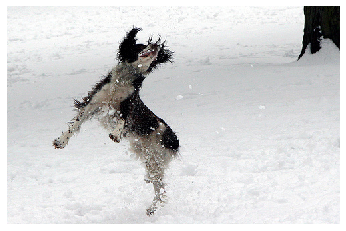

Image path for file: C:/Users/JordanLaptop/Desktop/AICW2/images/576075451_5e0f6facb3.jpg
Captions for image 1 :
BlueScore: 0
Predicted:  ['march', 'pole', 'cowboy', 'astride', 'astride', 'streamers', 'ribbon', 'chef', 'rowing', 'aim', 'arm', 'bit', 'nude', 'elderly', 'garage', 'girls', 'record', 'i', 'shoulder', 'pointed']
a black and white dog jumping in the air surrounded by snow
black and white dog jumping up in the snow 
dog jumping in the snow near a tree 
shaggy little dog jumps in the snow 
the white and black dog leaped into the air and off the snowy ground 


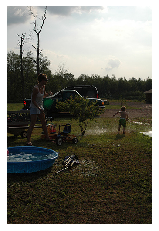

Image path for file: C:/Users/JordanLaptop/Desktop/AICW2/images/974924582_10bed89b8d.jpg
Captions for image 2 :
BlueScore: 0
Predicted:  ['meet', 'apartment', 'little', 'goofy', 'swords', 'raised', 'florida', 'tiger', 'circle', 'floor', 'pictures', 'gigolo', 'grinning', 'messy', 'displays', 'size', 'smooth', 'breed', 'tips', 'ramp']
a child is running away from a plastic pool and an adult on a rural setting 
a child is running away from a woman standing by a paddling pool 
a child playing with a water hose while a woman records with a camcorder
a woman and her son are playing outside by a kiddie pool 
a woman watches a child play near a small pool 
[0]
[0]


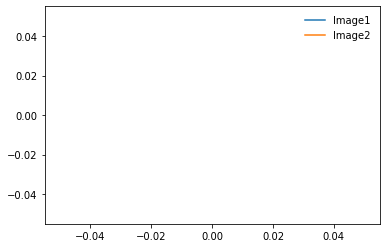

.................................................................
Blue Score:
[0.0]


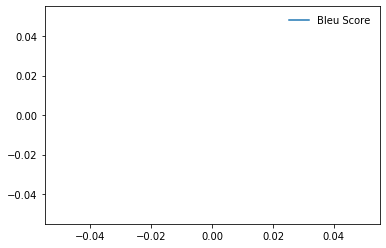

.................................................................
Epoch [0/5], Step [0/301], Loss: 8.1484


KeyboardInterrupt: 

In [88]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
total_step = len(train_loader) 
train_losses = [] 
running_loss = 0.0
for epoch in range(num_epochs):
    bluescores(images1, labels1, lengths1) 
   
    for i, (images, captions, lengths) in enumerate(train_loader):
        # Set mini-batch dataset 
        images = images.to(device)
        captions = captions.to(device)
         # Packed as well as we'll compare to the decoder outputs
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]     
        # Forward, backward and optimize
        features = encoder(images)## image tensor values
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        # Zero gradients for both networks
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()  
        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch, num_epochs, i, total_step, loss.item()))
        running_loss += loss.item()
        running_loss = running_loss / len(train_loader)
    train_losses.append(running_loss)
    plt.plot(train_losses, label='Training loss')
    plt.legend(frameon=False)
    plt.show()
bluescores(images1, labels1, lengths1) 
dataiter =iter(test_loader) 
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)
plt.show()

images_captions_scores_test(5, images2, labels2, lengths2)
         # If you want to save the model checkpoints - recommended once you have everything working
        # Make sure to save RNN and LSTM versions separately
        # if (i+1) % save_step == 0:
        #   torch.save(decoder.state_dict(), model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
        #   torch.save(encoder.state_dict(), model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

In [ ]:
#torch.save(decoder.state_dict(), "attn_decoderLSTM.pt")
#torch.save(encoder.state_dict(), "encoderLSTM.pt")



#torch.save(decoder.state_dict(), "attn_decoder1lstm.pt")
#torch.save(encoder.state_dict(), "encoder1lstm.pt")

In [ ]:
device = torch.device("cuda")
#encoder.load_state_dict(torch.load("encoder1.pt")) 
#decoder.load_state_dict(torch.load("attn_decoder1.pt")) 


encoder.load_state_dict(torch.load("attn_decoder1lstm.pt")) 
decoder.load_state_dict(torch.load("encoder1lstm.pt")) 

In [ ]:
plt.imshow(p2)

In [ ]:
# This is the function that is called during each epoch to fish the images, 


name = []
bleuscore = []
length = []

def images_captions_scores_test(num_of_cases, images, captions, lengths):
    # Open the logging file to keep track.
    # Put encoder and decoder into evaluate mode.
    encoder.eval()
    decoder.eval()
    # Move image and caption tensors onto the GPU.
    images = images.to(device)
    captions = captions.to(device)
    # Put the images and captions through the model.
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    # Take the first few entries of the captions tensor and condense them into lists.
    first_ids = captions[:num_of_cases].tolist()
    # Use our predefined functions to convert to captions, and add to a new list.
    first_cap = []
    for i in first_ids:
        first_cap.append(word_list(i, vocab))
    # Show the image title for each caption.
    first_img = []
    for i in first_cap:
            first_img.append(image_dir + get_image_name(i))
    allcaptions = []
    for i in first_cap:
            allcaptions.append(get_other_captions(i))
    reference, predicted, i, predictstring, longcaps, shortcaps = [], [], 0, [], [], []
    smoothing, BLEUscoreslist = SmoothingFunction(), []   
    for i in decoder.sample(features[:num_of_cases]):
        x = (word_list(i.cpu().numpy(), vocab))
        predicted.append(word_list(i.cpu().numpy(), vocab))
    for i in range(num_of_cases):
        predictstring.append(''.join(j + ' ' for j in predicted[i]))
    for i in range(num_of_cases):
        x = word_list(captions.cpu().numpy()[i] , vocab)
        caption = ' '.join(x)
        i += 1
        x = get_other_captions(x)
        captiontoadd = [caption.split() for caption in x]
        reference.append(captiontoadd)
    for i in range(len(first_img)):
        # Image plotting.
        image = mpimg.imread(first_img[i])
        plt.axis('off')
        plt.imshow(image)
        plt.savefig('TestImage' + str(i + 1) + '.jpg', bbox_inches='tight')
        plt.show()
        # Caption display.
        print('Testing image ' + str(i + 1) + ' filepath: ' + first_img[i])
        print('Testing image ' + str(i + 1) + ' captions:')
        
        for j in allcaptions[i]:
            print(j)
        print('\n')
        BLEUscoreslist.append(sentence_bleu(reference[i], predicted[i], smoothing_function = smoothing.method1))
        print('Predicted caption ' + str(i + 1)+ " "+predictstring[i]+ ' BLEU score: ' + str(BLEUscoreslist[i]))
        # Add an extra new line to space out the output.
        print('\n')


In [ ]:
#dataiter =iter(test_loader) 
#images2, labels2, lengths2 = dataiter.next()
data1 = {
    'Name': name,
    'Bluescore': bleuscore,
    'Length': length
}
data_df1 = pd.DataFrame(data1, columns=['Name', 'Bluescore', 'Length'])

In [ ]:

images_captions_scores_test(40, images2, labels2, lengths2)

In [ ]:
# This is the function that is called during each epoch to fish the images, 


name = []
bleuscore = []
length = []

def images_captions_scores_test2(num_of_cases, images, captions, lengths):
    # Open the logging file to keep track.
    # Put encoder and decoder into evaluate mode.
    encoder.eval()
    decoder.eval()
    # Move image and caption tensors onto the GPU.
    images = images.to(device)
    captions = captions.to(device)
    # Put the images and captions through the model.
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    # Take the first few entries of the captions tensor and condense them into lists.
    first_ids = captions[:num_of_cases].tolist()
    # Use our predefined functions to convert to captions, and add to a new list.
    first_cap = []
    for i in first_ids:
        first_cap.append(word_list(i, vocab))
    # Show the image title for each caption.
    first_img = []
    for i in first_cap:
            first_img.append(image_dir + get_image_name(i))
    # Get the other captions, given one of them.
    allcaptions = []
    for i in first_cap:
            allcaptions.append(get_other_captions(i))
    # Now we went to plot the image and show the captions alongside it.
    for i in range(len(first_img)):
        # Image plotting.
        image = mpimg.imread(first_img[i])
        # Caption display.
        # Add an extra new line to space out the output.
    # Now, we want to display one of the reference captions for each image.

    reference, predicted, i, predictstring, longcaps, shortcaps = [], [], 0, [], [], []
    # Loop through the available captions and return them.
    
    for i in range(num_of_cases):

        x = word_list(captions.cpu().numpy()[i] , vocab)
 
            
        caption = ' '.join(x)
        i += 1
        x = get_other_captions(x)
        captiontoadd = [caption.split() for caption in x]
        
        reference.append(captiontoadd)
        # Print these out and add to the log file.
    
        
    # Now we fetch the predicted captions from the decoder.
    for i in decoder.sample(features[:num_of_cases]):
        
        x = (word_list(i.cpu().numpy(), vocab))
            
        predicted.append(word_list(i.cpu().numpy(), vocab))
    # Convert these lists into strings and display them.
    for i in range(num_of_cases):
        predictstring.append(''.join(j + ' ' for j in predicted[i]))
    # Now, lets generate the BLEU score with smoothing. 
    smoothing, BLEUscoreslist = SmoothingFunction(), []
    for j in range(num_of_cases):
        noword = 0
        for word in predicted[j]:
            noword = noword+1
        BLEUscoreslist.append(sentence_bleu(reference[j], predicted[j], smoothing_function = smoothing.method1))
        # Lets display the BLEU score of each predicted caption.
        
        name.append(predictstring[j])
        bleuscore.append(BLEUscoreslist[j])
        length.append(noword)
    # Add another new line space to the output.

In [ ]:
dataiter =iter(test_loader) 
images2, labels2, lengths2 = dataiter.next()

In [ ]:
images_captions_scores_test2(256, images2, labels2, lengths2)

In [ ]:
len(test_loader)

In [ ]:
for i, (images3, captions3, lengths3) in enumerate(test_loader):
    images_captions_scores_test2(250, images3, captions3, lengths3)


In [ ]:
data1 = {
    'Name': name,
    'Bluescore': bleuscore,
    'Length': length
}
data_df1 = pd.DataFrame(data1, columns=['Name', 'Bluescore', 'Length'])

In [ ]:
data_df1

In [ ]:
len(dataset_test)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

data_df1.hist(column='Length', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

In [ ]:
d = {
    'Caption': captionTXT,
    'Lengths': lengths,
}


In [ ]:
data3 = data_df1.groupby(['Length']).mean()
data3
ax = data3.plot.bar(y='Bluescore', rot=0)

In [ ]:
captionTXT = captions
x = []
lengths = []
for c in captionTXT:
    x.append(c.split())

for i in x: 
    lengths.append(len(i))


d = {
    'Caption': captionTXT,
    'Lengths': lengths,
}


df = pd.DataFrame(d, columns=['Caption', 'Lengths'])
df.plot.hist(bins=17)